# Module Imports

In [16]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Data
Small dataset of handwritten zeros: [Optical Recognition of Handwritten Digits](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)

First, we need to create a custom dataloader for this dataset.

In [17]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for dataset"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        
        :param csv_file: Path to the csv file with annotations
        :param label: Directory with all the images
        :param transform: Optional transform to be applied on a sample
        """

        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        return image, 0        
        

Create Dataloader Instance

In [18]:
image_size = 8    # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
csv_file_path = "optical+recognition+of+handwritten+digits/optdigits.tra"
dataset = DigitsDataset(csv_file=csv_file_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Visualize some data

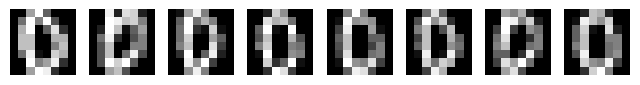

In [19]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size, image_size)
    plt.subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')
    
plt.show()

# Implementing the Discriminator $D$
For the discriminator we use a fully connected neural network with 2 hidden layers. A single output is sufficient to represent the probability of an input being classified as real

Input 8x8 -> 64 -> 16 -> 1
In Image -> Out probability of beeing a zero

In [20]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            # Inputs for 1. hidden layer -> 64 neurons
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.model(x)
    

# Implementing the Generator
<div>
<img src="qcircuit.jpeg" alt="Quantum Circuit" width="500" />
</div>

In [21]:
# Quantum variables
n_qubits = 5    # Total number of qubits -> N
n_a_qubits = 1    # Number of ancillary qubits -> N_A
q_depth = 6    # Depth of the parameterised quantum circuit -> D
n_generators = 4    # Number of subgenerators for the patch method -> N_G


In [22]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\dev\quantum-project\venv\lib\site-packages\pennylane_lightning\lightning_qubit\lightning_qubit.py:824: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


In [23]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):
    
    weights = weights.reshape(q_depth, n_qubits)
    
    # Initialise hidden (latent) vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)
        
    # Repeated Layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)
            
        # Control Z gates (Pauli-Z)
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])
            
    return qml.probs(wires=list(range(n_qubits)))


def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2**(n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)
    
    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven


## Quantum Generator

In [24]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""
    
    def __init__(self, n_generators, q_delta=1):
        """
        
        :param n_generators: Number of sub-generators to be used in the patch method.
        :param q_delta: Spread of the random distribution for parameter initialisation
        """
        
        super().__init__()
        
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
            ]
        )
        
        self.n_generators = n_generators
        
    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)
        
        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size
        images = torch.Tensor(x.size(0), 0).to(device)
        
        # Iterate over all sub-generators
        for params in self.q_params:
            
            patches = torch.Tensor(0, patch_size).to(device)
            for element in x:
                q_out = partial_measure(element, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))
            
            images = torch.cat((images, patches), 1)
                
        return images

# Training

In [25]:
lrG = 0.3    # Learning rate for the generator
lrD = 0.01    # Learning rate for the discriminator
num_iter = 500 # Number of training iterations

In [26]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training

fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):
        
        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)
        
        # Noise following a uniform distribution in range [0, pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)
        
        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)
        
        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        optD.step()
        
        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()
        
        counter += 1
        
        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()
            
            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)
        
        if counter == num_iter:
            break
    
    if counter == num_iter:
        break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x16 and 64x64)